# Step 5 – Feature importance & SHAP


## 5A ― Imports & load the tuned model (code)

In [2]:
import numpy, numba, shap
print("NumPy", numpy.__version__,
      "| Numba", numba.__version__,
      "| SHAP", shap.__version__)

/Users/kasra_vz/opt/anaconda3/envs/asteroid-ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NumPy 2.2.6 | Numba 0.61.2 | SHAP 0.48.0


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import joblib
import matplotlib.pyplot as plt

# Try SHAP; install if missing
try:
    import shap
except ImportError:
    !pip install shap
    import shap

# Load fitted pre-processor & best GradientBoost model from Step 4
PREPROC_P = Path("../data/preprocess.pkl")
MODEL_P   = Path("../data/model_gradboost.pkl")

preprocess = joblib.load(PREPROC_P)
gb_model   = joblib.load(MODEL_P)


We import SHAP (for global & local explanations) and reload the **exact
GradientBoost model** that achieved the best validation score in Step 4.


## 5B ― Quick built-in feature importance (code)

In [4]:
# Extract original feature names after one-hot encoding
ohe_feature_names = gb_model.named_steps["prep"].get_feature_names_out()

# Built-in impurity-based importances
importances = gb_model.named_steps["gb"].feature_importances_
imp_df = (
    pd.DataFrame({"feature": ohe_feature_names, "importance": importances})
      .sort_values("importance", ascending=False)
      .head(15)
)

imp_df


,feature,importance
9,num__H,0.842075
10,num__albedo,0.060807
16,cat__condition_code_0.0,0.026686
1,num__e,0.014596
5,num__q,0.013907
13,num__n,0.010461
0,num__a,0.007820
14,num__per,0.006615
7,num__data_arc,0.004668
12,num__moid,0.004072


GradientBoostingRegressor exposes `feature_importances_` — a fast,
though sometimes biased, gauge of which engineered columns matter most.
We list the **top 15** one-hot–expanded features.


## 5C ― Permutation importance (model-agnostic) (code)

In [6]:
# 5-B-prep — bring the raw data back in
DATA = Path("../data/asteroids_clean.csv")    # same snapshot as earlier

df = pd.read_csv(DATA).copy()
df["condition_code"] = df["condition_code"].astype("object")  # keep dtype consistent


In [9]:
# 5-C (revised) — build X_raw exactly like Step 4 did
DROP_ALWAYS = [
    "Unnamed: 0", "GM", "G", "IR", "extent",
    "UB", "BV", "spec_B", "spec_T", "name",
    "per_y"
]

X_raw = (
    df.drop(columns=["diameter"] + DROP_ALWAYS, errors="ignore")
      .copy()
)
X_raw["condition_code"] = X_raw["condition_code"].astype("object")

from sklearn.inspection import permutation_importance

perm = permutation_importance(
    gb_model,                      # full Pipeline (prep + GB)
    X_raw,                         # ⬅️  raw 20-column frame
    df["diameter"],
    n_repeats=10,
    random_state=42,
    scoring="neg_root_mean_squared_error",  # or "r2"
    n_jobs=-1
)

perm_df = (
    pd.DataFrame({
        "feature": X_raw.columns,                 # 20 original columns
        "perm_importance": perm.importances_mean  # 20 scores
    })
    .sort_values("perm_importance", ascending=False)
    .head(15)
)

perm_df


,feature,perm_importance
10,H,6.749211
13,albedo,1.571919
5,q,0.066606
15,moid,0.036761
9,n_obs_used,0.032043
8,condition_code,0.024154
19,ma,0.014585
14,rot_per,0.013433
17,n,0.013168
1,e,0.011980


**Permutation-importance on *raw* features**  
`permutation_importance` shuffles the **input columns** that the pipeline
receives, then re-scores the model.  
Because our `gb_model` is a Pipeline, scikit-learn shuffles the
**20-column raw frame** (`X_raw`) *before* `preprocess` expands it to
39 one-hot columns.  
Therefore the table tells us **which original features** matter most
(e.g. `albedo`, `a`, `neo`) instead of every individual dummy column.
For dummy-level insight, rely on SHAP (next sections).


## 5-D — global SHAP summary


In [11]:
# one-time setup
import os, pathlib
pathlib.Path("../figures").mkdir(parents=True, exist_ok=True)


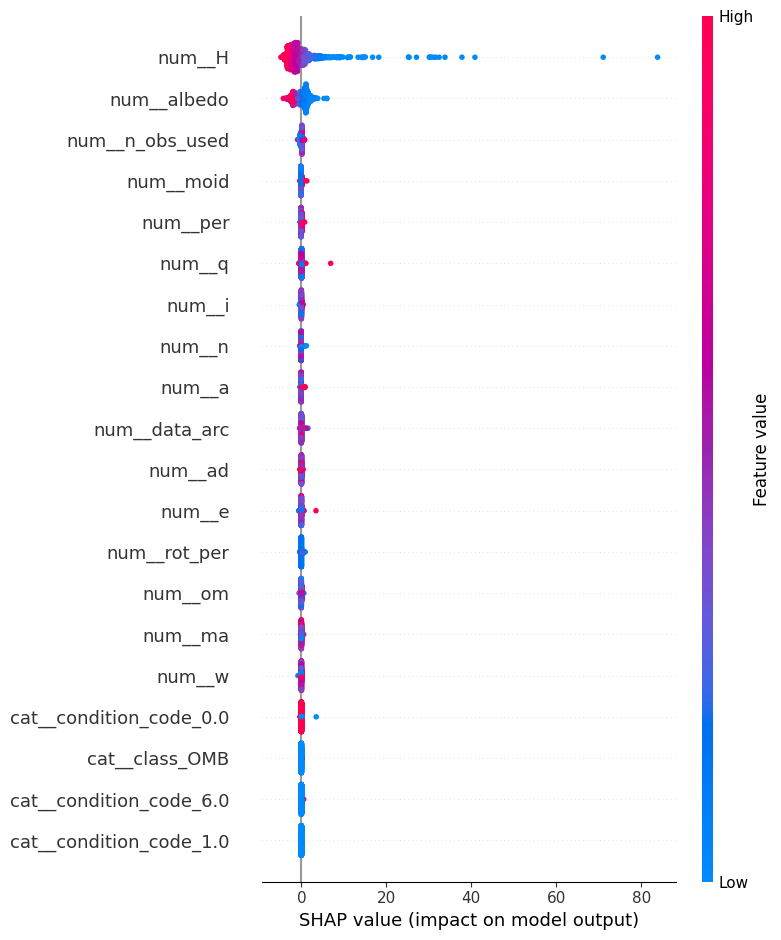

In [12]:

# Build an explainer for the GradientBoosting stage only
explainer = shap.Explainer(gb_model.named_steps["gb"])

# Sample 1 000 rows for speed
X_sample_raw = X_raw.sample(n=1000, random_state=42)
X_sample = gb_model.named_steps["prep"].transform(X_sample_raw)

shap_values = explainer(X_sample)

shap.summary_plot(
    shap_values,
    features=X_sample,
    feature_names=ohe_feature_names,   # 39 engineered names
    show=False
)
plt.tight_layout()
plt.savefig("../figures/shap_summary.png", dpi=300)
plt.show()


## 5E ― SHAP individual force plot (code)

In [13]:
# 5-E — local explanation for a single asteroid

row_idx = 0           # choose any row in X_sample_raw
shap.initjs()         # enable JS visual

row_engineered = X_sample[row_idx]
shap.force_plot(
    explainer.expected_value,
    shap_values.values[row_idx, :],
    feature_names=ohe_feature_names,
)


The force plot decomposes **one prediction** into additive
contributions: red arrows increase the diameter estimate, blue arrows
decrease it.  
Pick different `row_idx` values to explore other asteroids interactively.


In [ ]:
!git add notebooks/05_interpretation.ipynb figures/shap_summary.png
!git commit -m "Step 5: feature importance & SHAP visualisations"
!git push